<a href="https://colab.research.google.com/github/cacbondioxit/Vietnamese-Accent-Adding/blob/main/DatasetPreproc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U evaluate sacrebleu accelerate wandb

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datasets import DatasetDict, Dataset
from datasets import load_dataset, load_metric

import transformers
from transformers import TextDataset, DataCollatorForLanguageModeling
# from transformers import DataCollatorForSeq2Seq
from transformers import GPT2Tokenizer, GPT2LMHeadModel
# from transformers import Trainer, TrainingArguments
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

import evaluate
import accelerate

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['PYTORCH_USE_CUDA_DSA'] = '1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [ ]:
checkpoint = "DezS/Accent-and-accentless-Vietnamese-dataset"
raw_dataset = load_dataset(checkpoint)

In [ ]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'AccentlessSentences'],
        num_rows: 4036379
    })
})

Text(0, 0.5, 'Frequency')

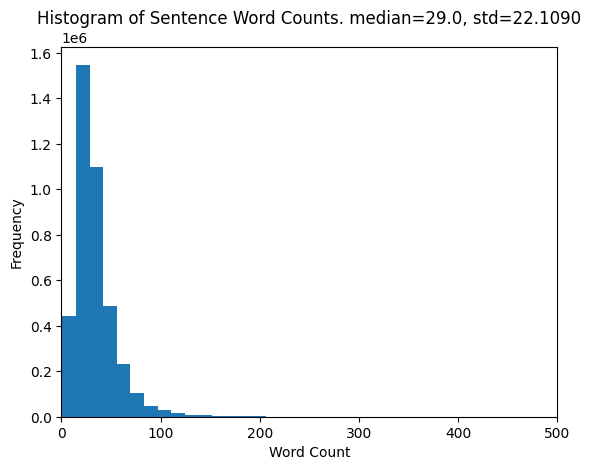

In [ ]:
sentences_word_counts = [len(sentence.split()) for sentence in raw_dataset['train']['Sentences']]
plt.hist(sentences_word_counts, bins=100)
plt.title(f"Histogram of Sentence Word Counts. median={np.median(sentences_word_counts)}, std={np.std(sentences_word_counts):.4f}")
plt.xlim([0, 500])
plt.xlabel("Word Count")
plt.ylabel("Frequency")

In [ ]:
# 남아있는 성조를 모두 제거

def remove_accents(s):
    s = re.sub(r'[àáạảãâầấậẩẫăằắặẳẵ]', 'a', s)
    s = re.sub(r'[ÀÁẠẢÃĂẰẮẶẲẴÂẦẤẬẨẪ]', 'A', s)
    s = re.sub(r'[èéẹẻẽêềếệểễ]', 'e', s)
    s = re.sub(r'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', s)
    s = re.sub(r'[òóọỏõôồốộổỗơờớợởỡ]', 'o', s)
    s = re.sub(r'[ÒÓỌỎÕÔỒỐỘỔỖƠỜỚỢỞỠ]', 'O', s)
    s = re.sub(r'[ìíịỉĩ]', 'i', s)
    s = re.sub(r'[ÌÍỊỈĨ]', 'I', s)
    s = re.sub(r'[ùúụủũưừứựửữ]', 'u', s)
    s = re.sub(r'[ƯỪỨỰỬỮÙÚỤỦŨ]', 'U', s)
    s = re.sub(r'[ỳýỵỷỹ]', 'y', s)
    s = re.sub(r'[ỲÝỴỶỸ]', 'Y', s)
    s = re.sub(r'[Đ]', 'D', s)
    s = re.sub(r'[đ]', 'd', s)
    return s

In [ ]:
# 성조 없애기 적용

updated_dataset = raw_dataset.map(lambda example: {"AccentRemovedSentences": remove_accents(example["AccentlessSentences"])},
                                  remove_columns=["AccentlessSentences"],
                                  num_proc=32, # multiprocessing
                                  )

/usr/local/lib/python3.10/dist-packages/multiprocess/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Map (num_proc=32):   0%|          | 0/4036379 [00:00<?, ? examples/s]

In [ ]:
updated_dataset = updated_dataset['train'].train_test_split(test_size=0.2, seed=42)
valid_test_dataset = updated_dataset['test'].train_test_split(test_size=0.5, seed=42)
splitted_dataset = DatasetDict({
    'train': updated_dataset['train'],
    'val': valid_test_dataset['train'],
    'test': valid_test_dataset['test'],
    })
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 3229103
    })
    val: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 403638
    })
    test: Dataset({
        features: ['Sentences', 'AccentRemovedSentences'],
        num_rows: 403638
    })
})

In [ ]:
splitted_dataset['train'][0]

{'Sentences': 'Tình cờ chị nghe thấy bà nói chuyện điện thoại trong buồng: "Ừ, Thuý à, mẹ đây, sao năm nay không thấy gọi điện chúc Tết bố mẹ nữa thế?',
 'AccentRemovedSentences': 'Tinh co chi nghe thay ba noi chuyen dien thoai trong buong: "U, Thuy a, me day, sao nam nay khong thay goi dien chuc Tet bo me nua the?'}

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained('NlpHUST/gpt2-vietnamese')

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

In [ ]:
def tokenize_function(example):
    result = tokenizer(example["AccentRemovedSentences"], text_target=example["Sentences"],
                       truncation=True, padding='max_length', max_length=200, return_special_tokens_mask=True)
    # del result['special_tokens_mask']
    return result

In [ ]:
transformers.logging.set_verbosity_error()

In [ ]:
splitted_dataset['val'] = splitted_dataset['val'].map(tokenize_function,
                                                      remove_columns=["Sentences", "AccentRemovedSentences"],
                                                      num_proc=32) # multiprocessing

Map (num_proc=32):   0%|          | 0/403638 [00:00<?, ? examples/s]

In [ ]:
splitted_dataset['val']

Dataset({
    features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
    num_rows: 403638
})

In [ ]:
splitted_dataset['val'][0]

In [ ]:
splitted_dataset['test'] = splitted_dataset['test'].map(tokenize_function,
                                                        remove_columns=["Sentences", "AccentRemovedSentences"],
                                                        num_proc=32)

Map (num_proc=32):   0%|          | 0/403638 [00:00<?, ? examples/s]

In [ ]:
# splitted_dataset['test'][0]

In [ ]:
splitted_dataset['train'] = splitted_dataset['train'].map(tokenize_function,
                                                          remove_columns=["Sentences", "AccentRemovedSentences"],
                                                          num_proc=32)

Map (num_proc=32):   0%|          | 0/3229103 [00:00<?, ? examples/s]

In [ ]:
# splitted_dataset['train'][0]

In [ ]:
splitted_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 3229103
    })
    val: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 403638
    })
    test: Dataset({
        features: ['input_ids', 'special_tokens_mask', 'attention_mask', 'labels'],
        num_rows: 403638
    })
})

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
splitted_dataset.push_to_hub("cacbon-dioxit/Vietnamese-Accent-Removed-dataset", private=True)